---
# Customer Churn Analysis and Retention Strategy for a Telecom Company
---

In [3]:
# Necessary Libraries
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set(style="whitegrid", palette="Set2")
plt.rcParams['figure.figsize'] = (8, 6)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

# Import the necessary models

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# metrics for measuring the accuracy of the trained models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

import joblib

In [5]:
# Create an "images" folder if it doesn't exist
os.makedirs("images", exist_ok=True)

_original_show = plt.show
_counter = 1  # Numbers figures automatically

def save_and_show(*args, **kwargs):
    """
    Replacement for plt.show() that also saves each figure as a PNG file.
    Files will be saved as: images/figure_1.png, images/figure_2.png, etc.
    """
    global _counter
    filename = f"images/figure_{_counter}.png"
    plt.savefig(filename, bbox_inches="tight", dpi=300)
    print(f"[INFO] Saved: {filename}")
    _counter += 1
    _original_show(*args, **kwargs)

# Override plt.show() globally
plt.show = save_and_show

print("Auto-save mode enabled: All future plots will be saved in the 'images/' folder.")

Auto-save mode enabled: All future plots will be saved in the 'images/' folder.


---
### Loading and Basic Cleaning
---

In [6]:
# Loading the dataset

data = pd.read_csv("/home/rishabh/Projects/archive/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(f"Rows = {data.shape[0]}, Columns = {data.shape[1]}")

Rows = 7043, Columns = 21


In [7]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# we do not need customerID for our analysis so we can drop that column

data = data.drop(columns="customerID")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


#### ⚠ Pay attention to the fact that TotalCharges is not numerical rather object data types, hence could have non-numerical entries

In [10]:
# Check for missing values

print(f"Missing values per column:\n{data.isnull().sum()}")

Missing values per column:
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [11]:
# Converting the TotalCharges to numeric format

data["TotalCharges"] = data["TotalCharges"].replace({" ": "0.0"})
data["TotalCharges"] = data["TotalCharges"].astype(float)

In [12]:
# Converting the SeniorCitizen to object format

data["SeniorCitizen"] = data["SeniorCitizen"].replace({0: "No", 1: "Yes"})
data["SeniorCitizen"] = data["SeniorCitizen"].astype(object)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


---
### Studying Target Distribution
---

In [14]:
# Churn rate

churn_rate = data["Churn"].value_counts(normalize=True) * 100
print(churn_rate)

Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


[INFO] Saved: images/figure_1.png


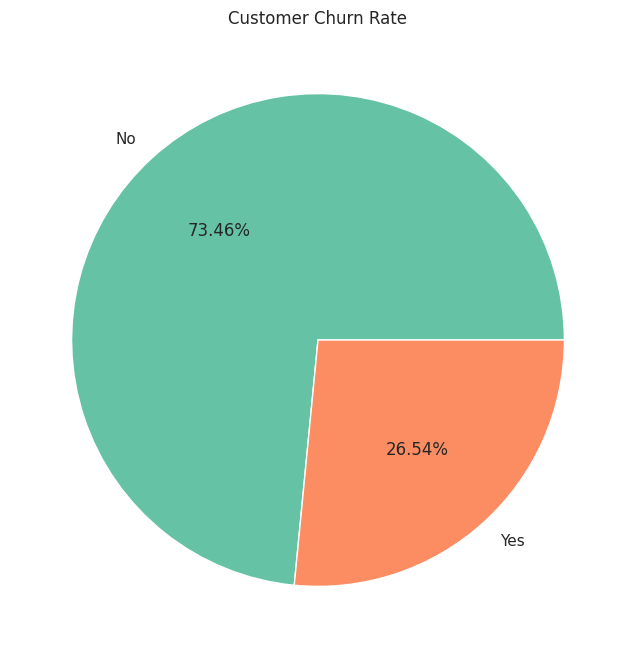

In [15]:
plt.figure(figsize=(10,8))
plt.pie(data["Churn"].value_counts(), labels=["No","Yes"], autopct='%.2f%%')
plt.title("Customer Churn Rate")
plt.show()

#### ⚠ Around 26.54% of customers churned which indicates moderate class imbalance. SMOTE could be employed to deal with it.

---
### Explortatory Data Analysis
---

[INFO] Saved: images/figure_2.png


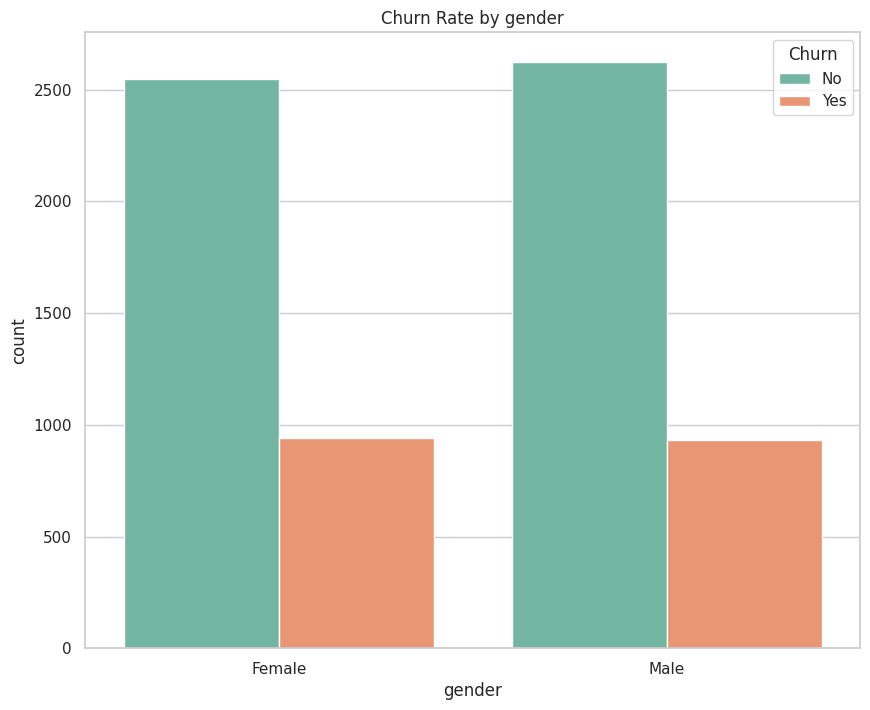

[INFO] Saved: images/figure_3.png


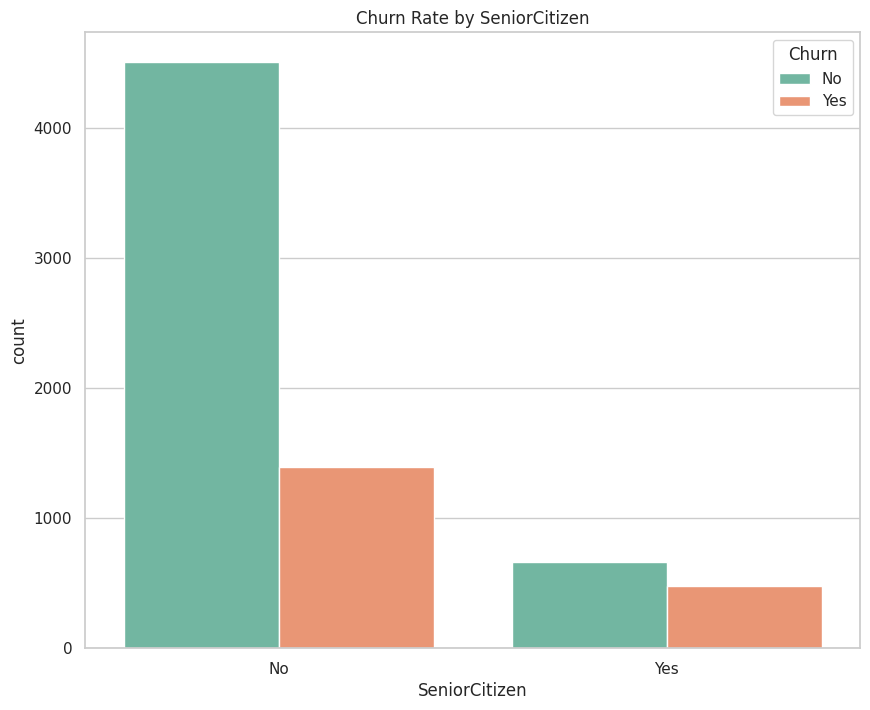

[INFO] Saved: images/figure_4.png


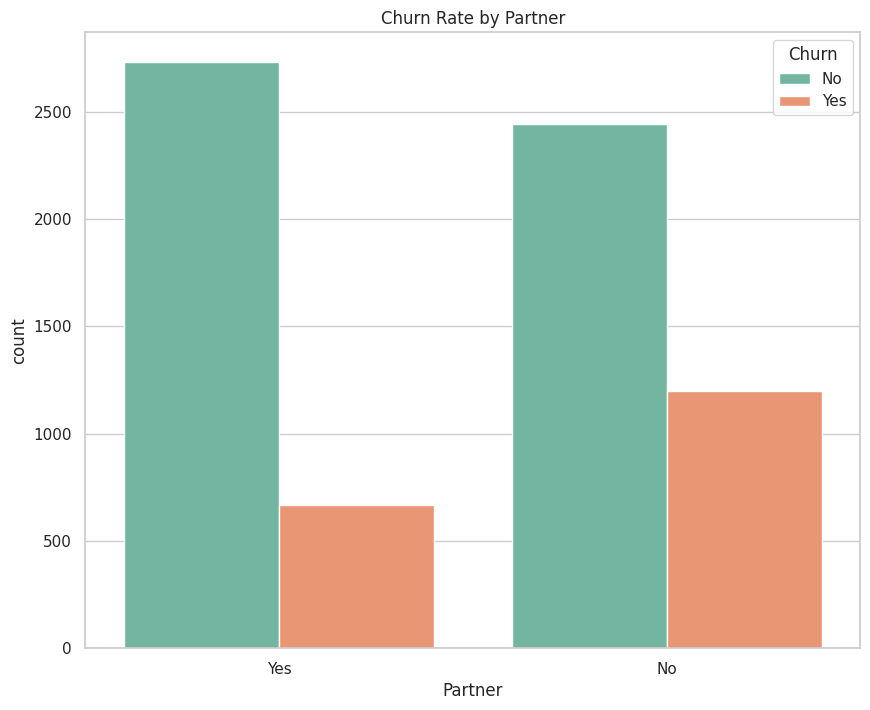

[INFO] Saved: images/figure_5.png


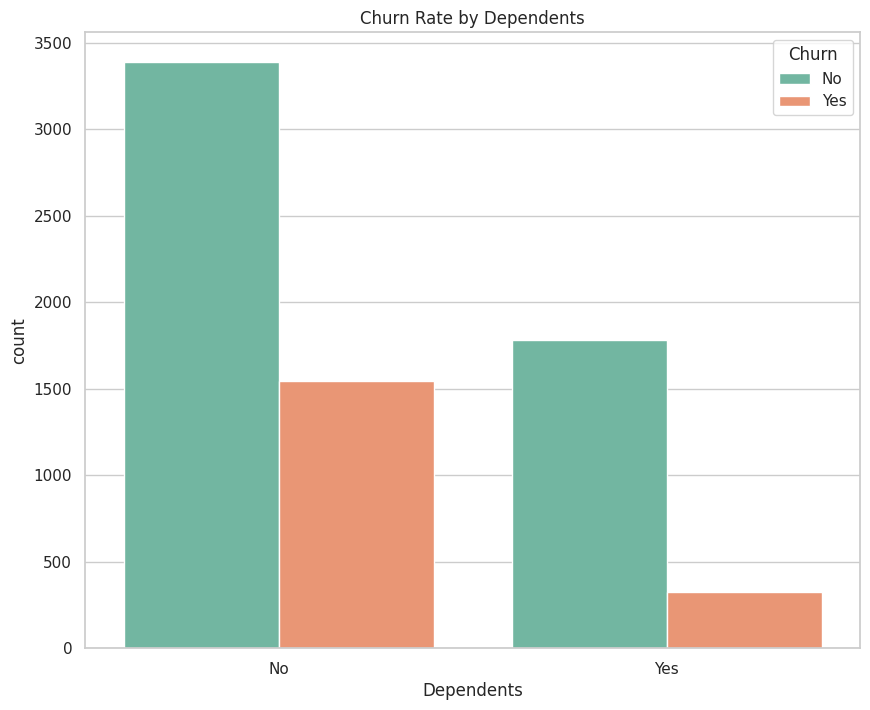

In [16]:
# Demographic features

demographic_list = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for col in demographic_list:
    plt.figure(figsize=(10,8))
    sns.countplot(x=col, hue='Churn', data=data)
    plt.title(f"Churn Rate by {col}")
    plt.show()

#### ⚠ Senior citizens and customers without dependents churn more frequently.

[INFO] Saved: images/figure_6.png


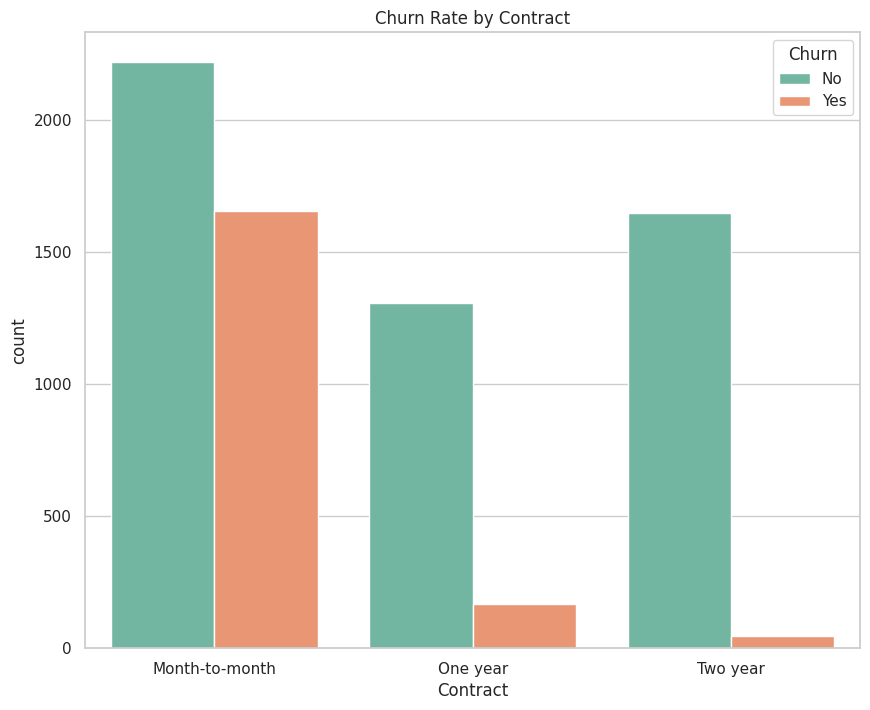

[INFO] Saved: images/figure_7.png


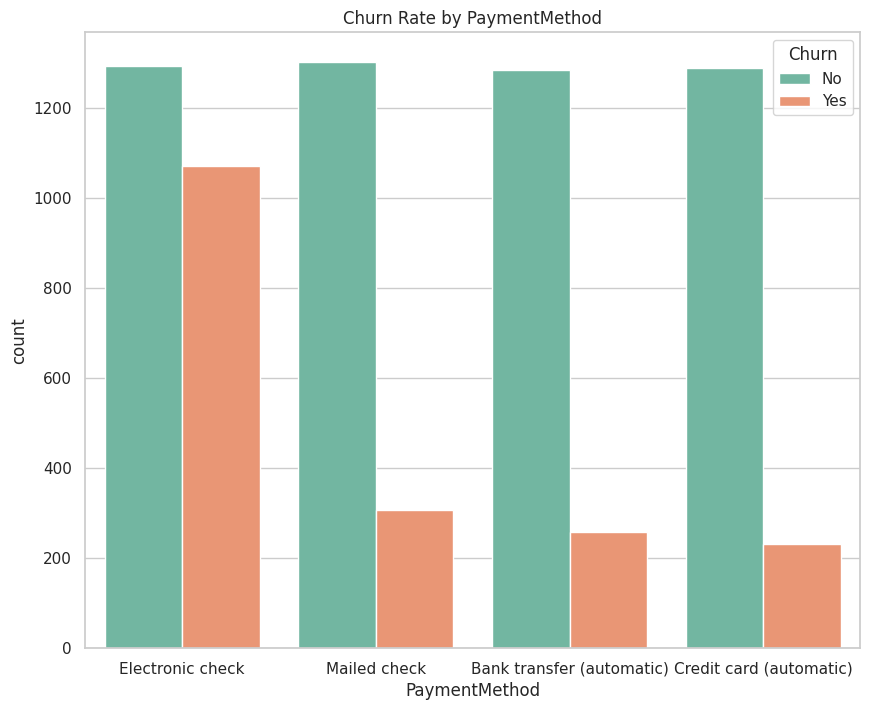

[INFO] Saved: images/figure_8.png


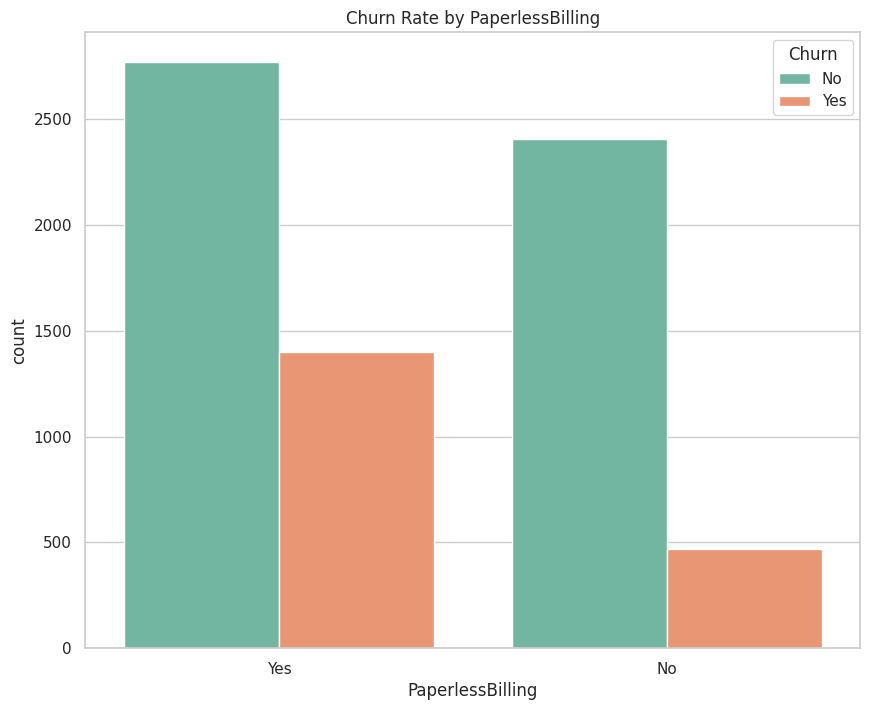

In [17]:
# Account related features

account_list = ['Contract', 'PaymentMethod', 'PaperlessBilling']

for col in account_list:
    plt.figure(figsize=(10,8))
    sns.countplot(x=col, hue='Churn', data=data)
    plt.title(f"Churn Rate by {col}")
    plt.show()

#### ⚠ Customers with month-to-month contracts and electronic check payment methods have higher churn rate.

[INFO] Saved: images/figure_9.png


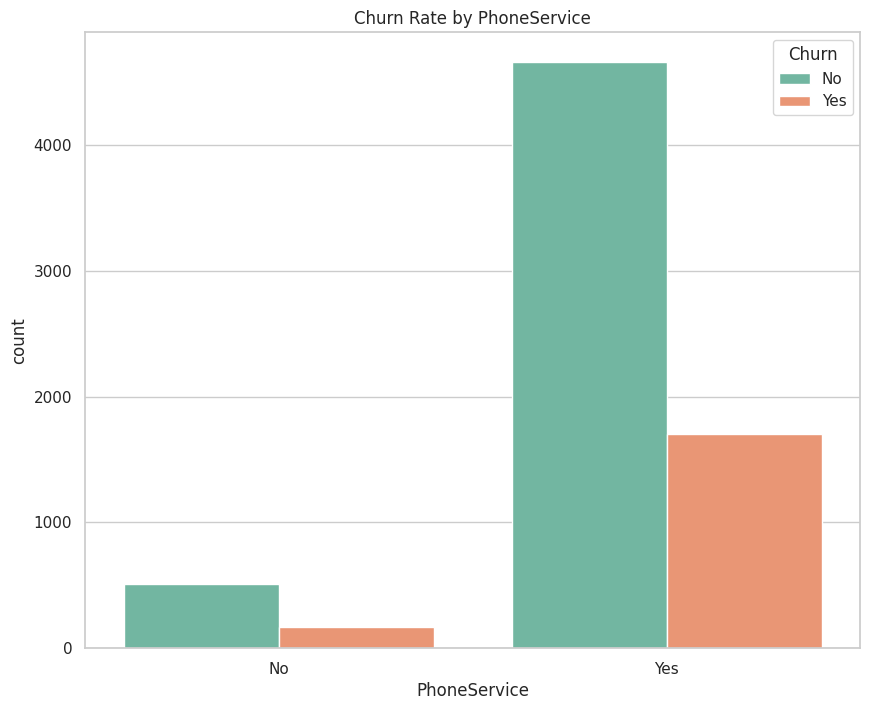

[INFO] Saved: images/figure_10.png


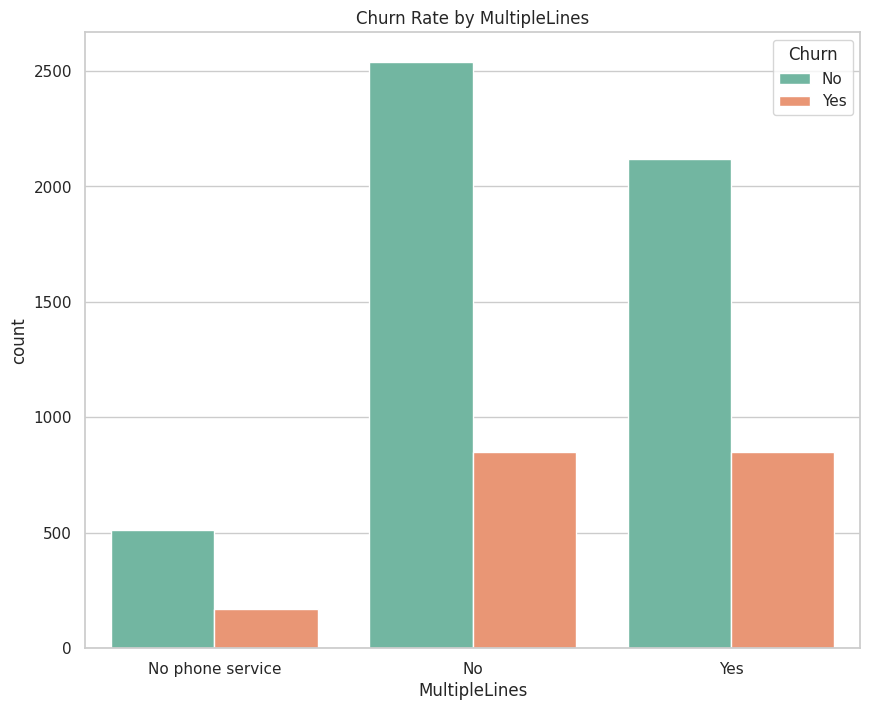

[INFO] Saved: images/figure_11.png


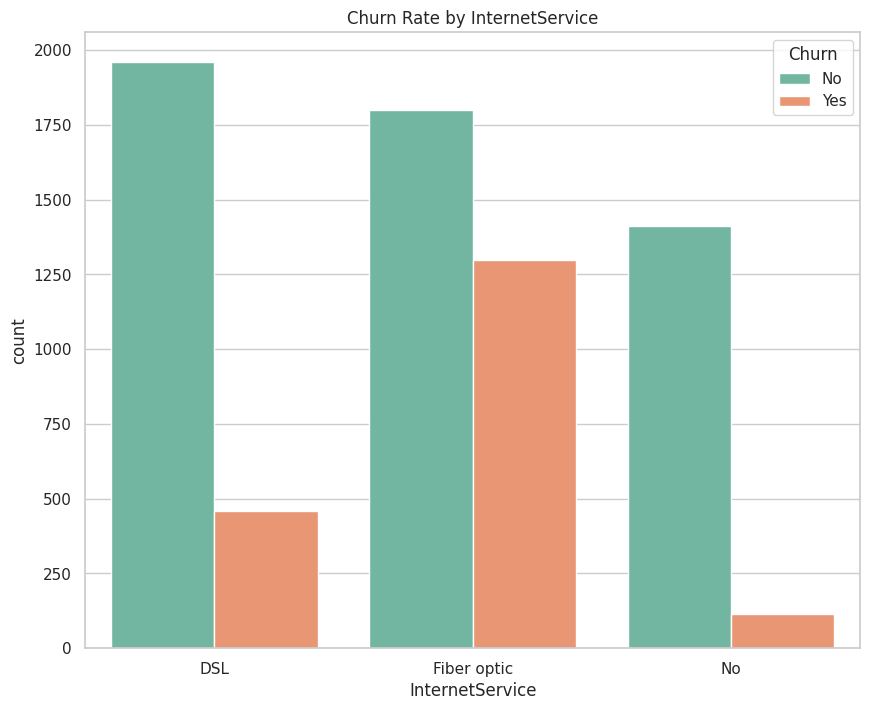

[INFO] Saved: images/figure_12.png


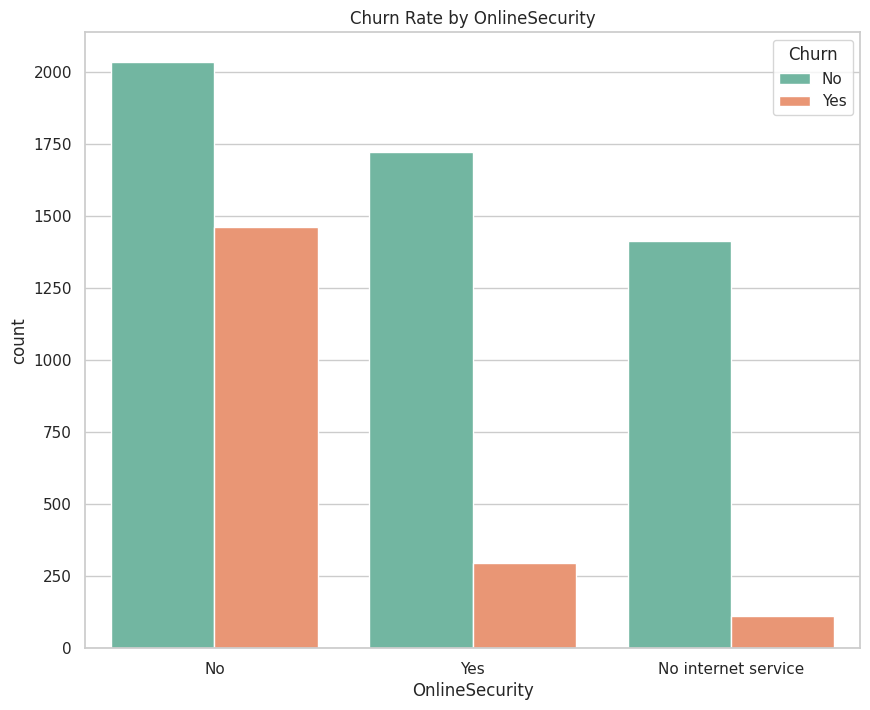

[INFO] Saved: images/figure_13.png


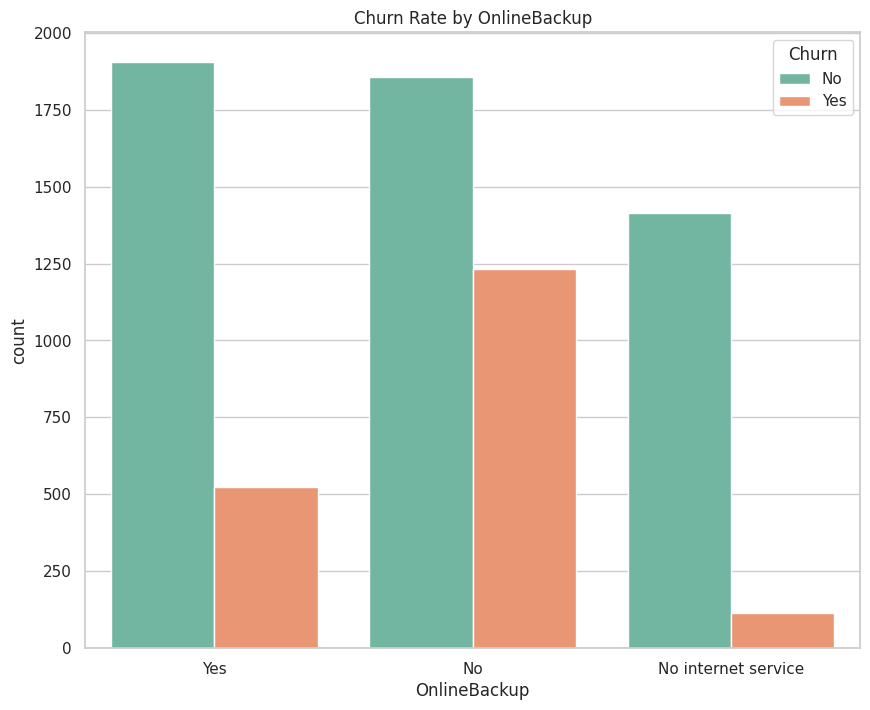

[INFO] Saved: images/figure_14.png


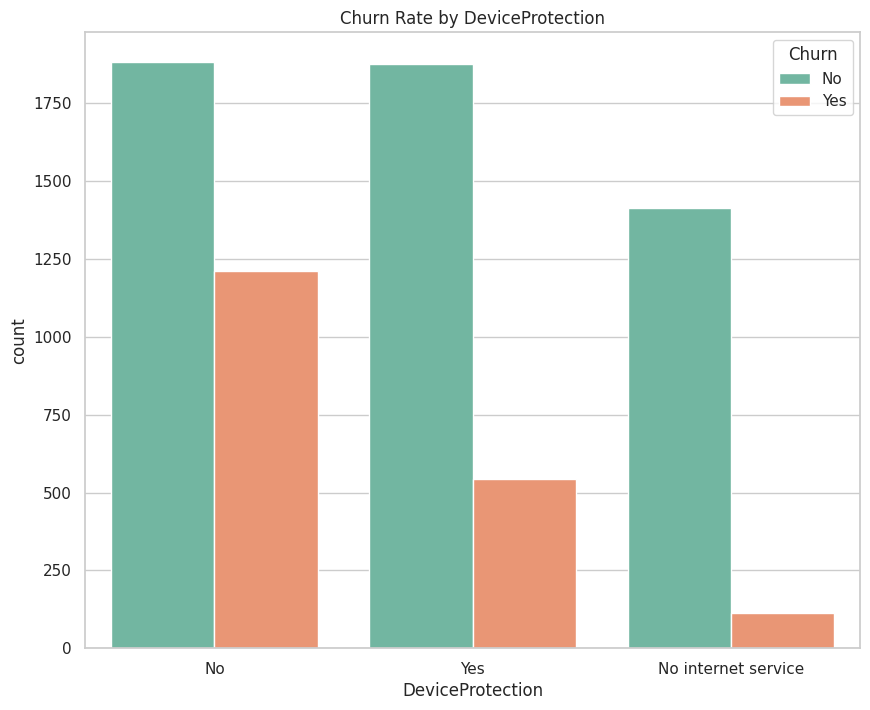

[INFO] Saved: images/figure_15.png


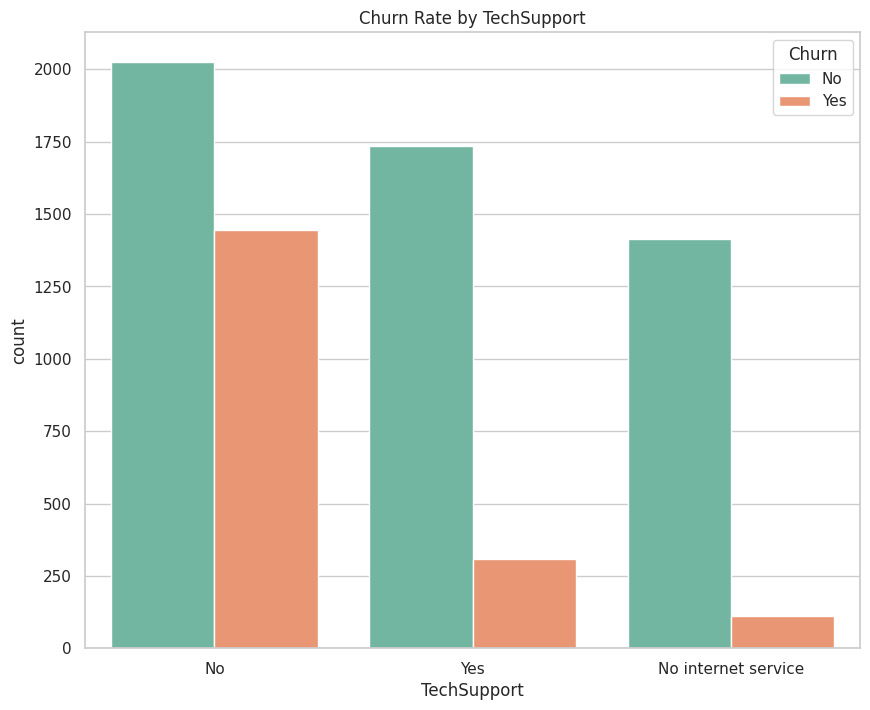

[INFO] Saved: images/figure_16.png


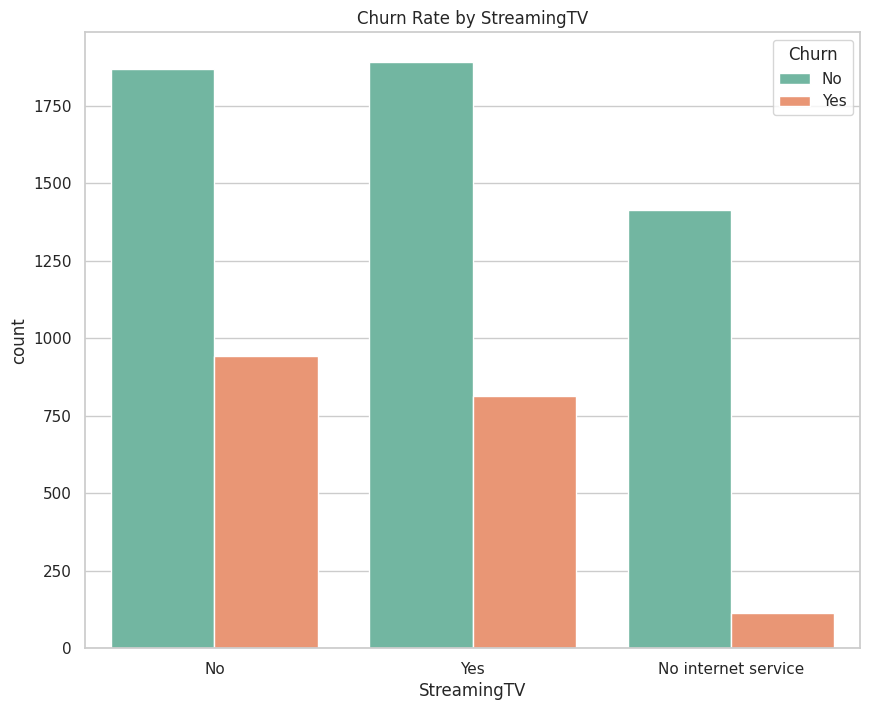

[INFO] Saved: images/figure_17.png


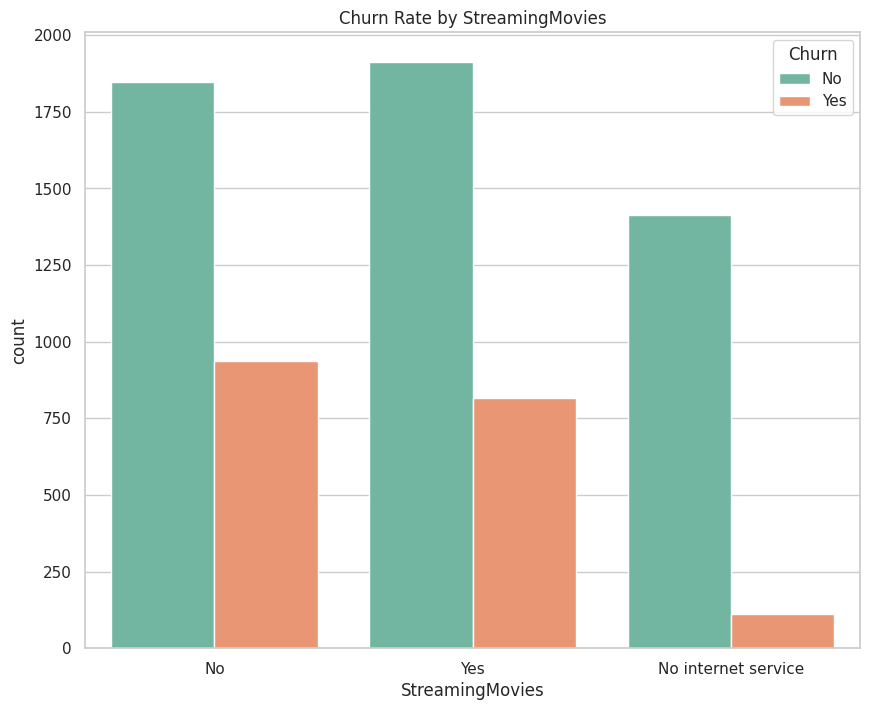

In [18]:
# Subscribed features

service_list = [
    'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

for col in service_list:
    plt.figure(figsize=(10,8))
    sns.countplot(x=col, hue='Churn', data=data)
    plt.title(f"Churn Rate by {col}")
    plt.show()

#### ⚠ Customers without OnlineSecurity or TechSupport are more likely to churn.

[INFO] Saved: images/figure_18.png


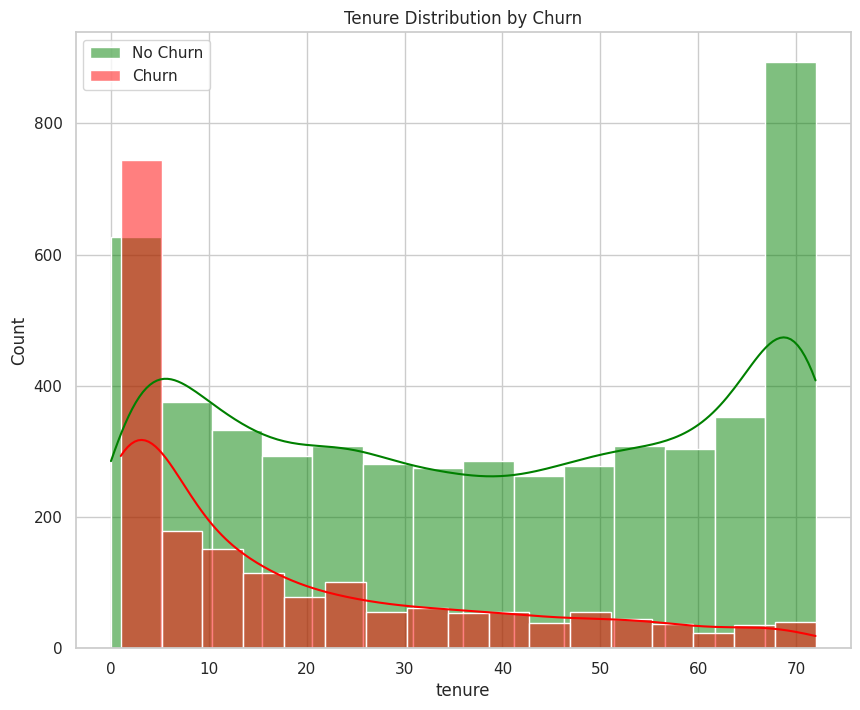

[INFO] Saved: images/figure_19.png


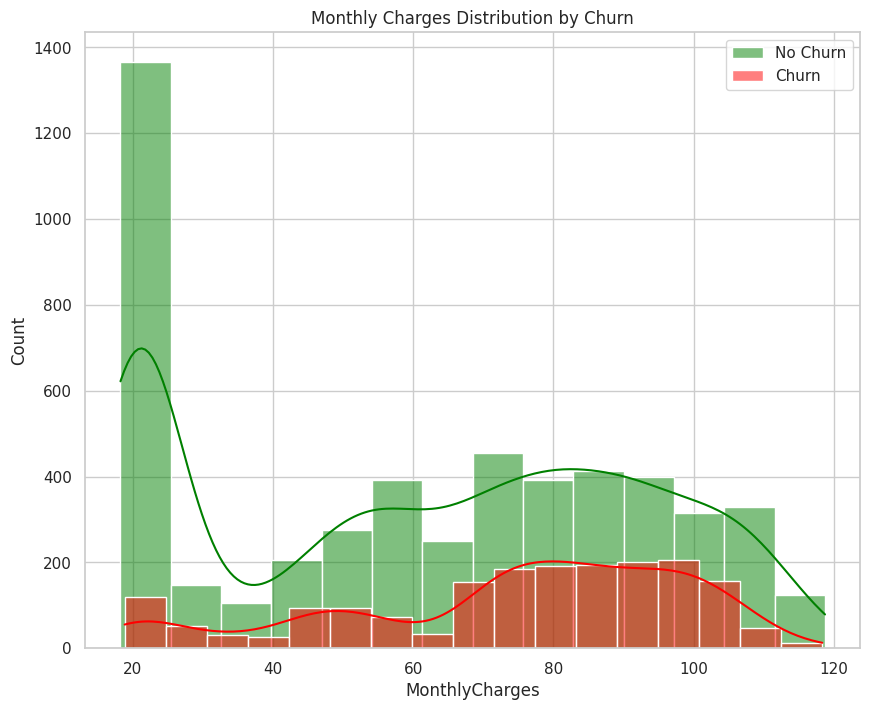

In [19]:
# Cost features

plt.figure(figsize=(10,8))
sns.histplot(data[data["Churn"]=="No"]["tenure"], color="green", kde=True, label="No Churn")
sns.histplot(data[data["Churn"]=="Yes"]["tenure"], color="red", kde=True, label="Churn")
plt.title("Tenure Distribution by Churn")
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
sns.histplot(data[data["Churn"]=="No"]["MonthlyCharges"], color="green", kde=True, label="No Churn")
sns.histplot(data[data["Churn"]=="Yes"]["MonthlyCharges"], color="red", kde=True, label="Churn")
plt.title("Monthly Charges Distribution by Churn")
plt.legend()
plt.show()


#### ⚠ Short-tenure customers (less than 12 months) churn more. High monthly charges may lead to increase churn risk.

In [20]:
# Check for outliers

data.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


[INFO] Saved: images/figure_20.png


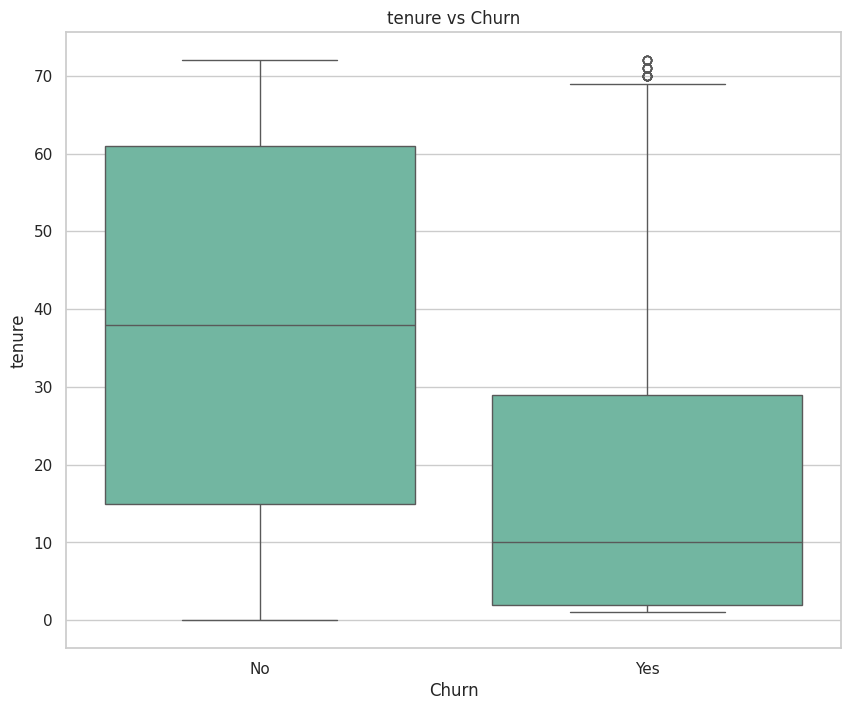

[INFO] Saved: images/figure_21.png


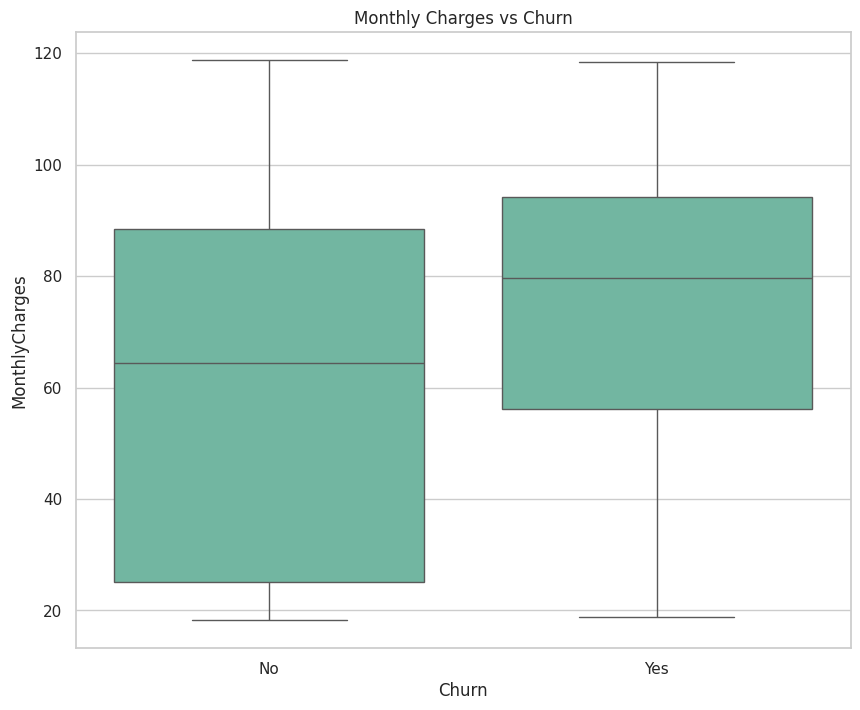

In [21]:
plt.figure(figsize=(10,8))
sns.boxplot(x="Churn", y="tenure", data=data)
plt.title("tenure vs Churn")
plt.show()

plt.figure(figsize=(10,8))
sns.boxplot(x="Churn", y="MonthlyCharges", data=data)
plt.title("Monthly Charges vs Churn")
plt.show()

#### ⚠  Some outliers exist for long tenured churned customers. This is a very small number of customers and ignoring them will not affect our modeling.

[INFO] Saved: images/figure_22.png


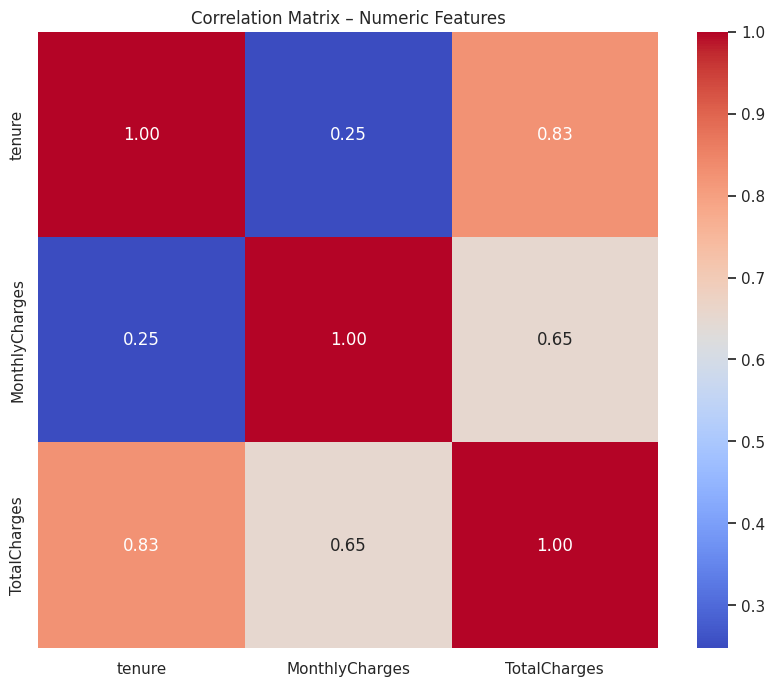

In [22]:
# Correlation of numerical features

numeric_data = data.select_dtypes(include=['int64', 'float64'])
corr = numeric_data.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix – Numeric Features")
plt.show()


#### ⚠ Tenure and total charges are strongly correlated, which makes sense as total charges is just tenure times monthly charges

/tmp/ipykernel_894/2653394479.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_summary = data.groupby('tenure_group')['Churn'].value_counts(normalize=True).unstack() * 100


[INFO] Saved: images/figure_23.png


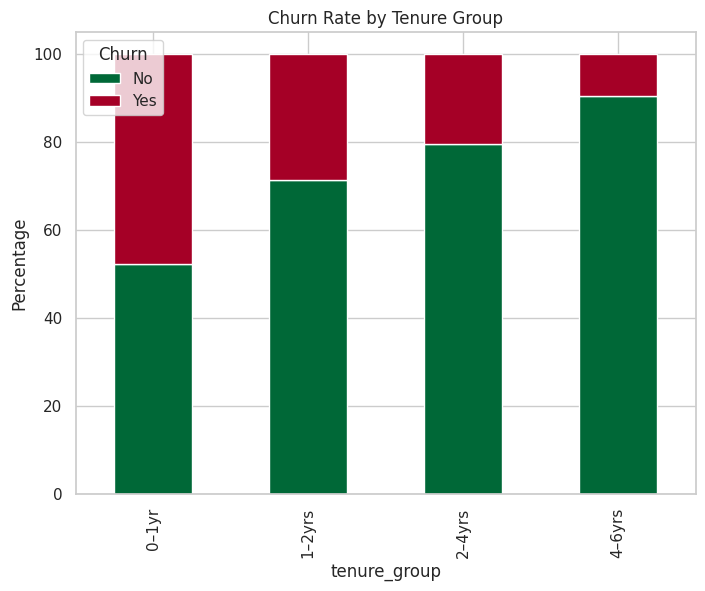

In [23]:
# Segmenting churn by tenure group

data['tenure_group'] = pd.cut(data['tenure'], bins=[0,12,24,48,72], labels=['0–1yr','1–2yrs','2–4yrs','4–6yrs'])
tenure_summary = data.groupby('tenure_group')['Churn'].value_counts(normalize=True).unstack() * 100
tenure_summary.plot(kind='bar', stacked=True, colormap='RdYlGn_r')
plt.title("Churn Rate by Tenure Group")
plt.ylabel("Percentage")
plt.show()

#### ⚠ Early lifecycle customers (first 12 months) have the highest churn probability.

---
### Business Insights
---

---
#### Key Insights:
---
1. Overall churn rate: ~26.54%
2. Month-to-month contracts show the highest churn rates.
3. Lack of TechSupport and OnlineSecurity strongly correlates with churn.
4. Customers with high monthly charges and short tenure are most at risk.
5. Senior citizens and those paying via electronic check churn more often.

---
#### Business Recommendations:
---
1. Offer loyalty incentives or discounts for month-to-month customers.
2. Create retention bundles that include TechSupport and OnlineSecurity.
3. Introduce onboarding campaigns to engage customers early.
4. Encourage customers to switch to auto-pay methods to reduce churn risk.
---

---
## Modeling and Comparison
---

In [29]:
# Preparing data for splitting 

data["Churn"] = data["Churn"].replace({"Yes": 1, "No": 0})

x = data.drop(["Churn","tenure_group"], axis=1)
y = data["Churn"]

categorical_list = x.select_dtypes(include=["object"]).columns.tolist()
numerical_list = x.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [30]:
# Test-train split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=16, stratify=y)

In [31]:
# Set-up a preprocessor

categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[("num", numerical_transformer, numerical_list),("cat", categorical_transformer, categorical_list)])

In [32]:
# Define all the relevant models

models = {
    "Logistic Regression": LogisticRegression(random_state=16),
    "Decision Tree": DecisionTreeClassifier(random_state = 16),
    "Random Forest": RandomForestClassifier(random_state=16),
    "XGBoost": XGBClassifier(random_state=42)
}

#### ⚠ Note: We find the best model and later perform gridsearch for best parameters. So for now we work with default parameters

In [34]:
# Training all the models and comparing

cross_valscore = []

for name, model in models.items():
    print("="*50)
    print(f"Training {name}...")
    print("="*50)
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),("smote", SMOTE(random_state=16)),("classifier", model)])
    ROC_scores = cross_val_score(pipeline, x_train, y_train, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=16), scoring = "roc_auc")
    ACC_scores = cross_val_score(pipeline, x_train, y_train, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=16), scoring = "accuracy")
    PRE_scores = cross_val_score(pipeline, x_train, y_train, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=16), scoring = "precision")
    RE_scores = cross_val_score(pipeline, x_train, y_train, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=16), scoring = "recall")
    F1_scores = cross_val_score(pipeline, x_train, y_train, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=16), scoring = "f1")
    cross_valscore.append({"Model":name,
        "Mean ROC-AUC": ROC_scores.mean(),
        "Accuracy": ACC_scores.mean(),
        "Precision": PRE_scores.mean(),
        "Recall": RE_scores.mean(),
        "F1": F1_scores.mean()
    })
    # cross_valscore[name] = scores
    print(f"ROC-AUC (per fold): {np.round(ROC_scores, 3)}")
    print(f"Mean ROC-AUC: {ROC_scores.mean():.4f} (+/- {ROC_scores.std():.4f})")
print("="*50)

Training Logistic Regression...
ROC-AUC (per fold): [0.844 0.843 0.831 0.854 0.827]
Mean ROC-AUC: 0.8400 (+/- 0.0098)
Training Decision Tree...
ROC-AUC (per fold): [0.658 0.654 0.647 0.674 0.656]
Mean ROC-AUC: 0.6580 (+/- 0.0090)
Training Random Forest...
ROC-AUC (per fold): [0.818 0.795 0.799 0.835 0.796]
Mean ROC-AUC: 0.8085 (+/- 0.0158)
Training XGBoost...
ROC-AUC (per fold): [0.822 0.814 0.799 0.831 0.801]
Mean ROC-AUC: 0.8135 (+/- 0.0122)


In [35]:
Compare_dataframe = pd.DataFrame(cross_valscore)
Compare_dataframe

,Model,Mean ROC-AUC,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.840003,0.747601,0.516121,0.793311,0.625268
1,Decision Tree,0.657963,0.717962,0.471909,0.528428,0.498433
2,Random Forest,0.808542,0.772983,0.577354,0.541137,0.558602
3,XGBoost,0.813511,0.775645,0.580400,0.559866,0.569679


[INFO] Saved: images/figure_24.png


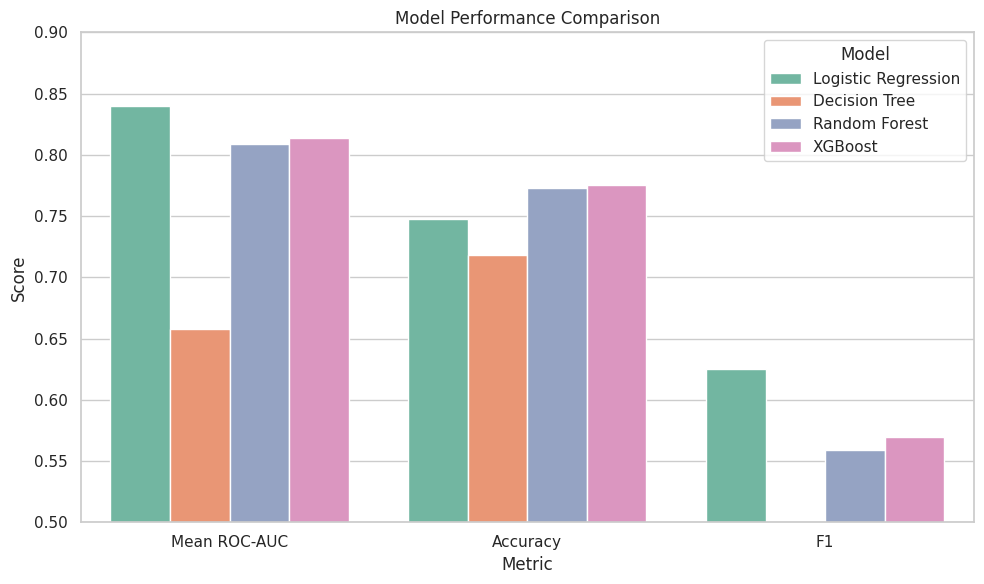

In [36]:
melted = Compare_dataframe.melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(10, 6))
sns.barplot(data=melted[melted["Metric"].isin(["Mean ROC-AUC", "Accuracy", "F1"])],
            x="Metric", y="Score", hue="Model")
plt.title("Model Performance Comparison")
plt.ylim(0.5, 0.9)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

#### ⚠ Logistic Regression seems to perform the best, however we still look at performance w.r.t the test set.

In [37]:
# Comparing the models on the test set
for name, model in models.items():
    print("="*50)
    print(f"Evaluating {name} on the test set")
    print("="*50)
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),("smote", SMOTE(random_state=16)),("classifier", model)])
    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    y_proba = pipeline.predict_proba(x_test)[:, 1]
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")
    print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
    print("Classification Report:\n", classification_report(y_test,y_pred))
print("="*50)

Evaluating Logistic Regression on the test set
ROC-AUC: 0.8619881681262757
Confusion Matrix:
 [[748 287]
 [ 62 312]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81      1035
           1       0.52      0.83      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.75      0.77      1409

Evaluating Decision Tree on the test set
ROC-AUC: 0.6891743522178304
Confusion Matrix:
 [[815 220]
 [153 221]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.79      0.81      1035
           1       0.50      0.59      0.54       374

    accuracy                           0.74      1409
   macro avg       0.67      0.69      0.68      1409
weighted avg       0.75      0.74      0.74      1409

Evaluating Random Forest on the test set
ROC-AUC: 0.8304722415975612
C

#### ⚠ Logistic Regression performs the best even in the case of test set. So we perform a gridsearch for parameters for this model only.

In [38]:
# Hyperparameter tuning for Logistic Regression model

param_grid = [{'classifier__penalty' : ['l1', 'l2', 'elasticnet', 'none'],'classifier__C' : [0.01, 0.1, 1, 5, 10],'classifier__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'classifier__max_iter' : [100, 1000,2500, 5000]}]

pipeline = Pipeline(steps=[("preprocessor", preprocessor),("smote", SMOTE(random_state=16)),("classifier", LogisticRegression(random_state = 16))])

grid_search = GridSearchCV(estimator=pipeline,param_grid=param_grid,cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=16),
                           scoring='roc_auc',n_jobs=-1,verbose=2)

In [ ]:
grid_search.fit(x_train, y_train)

print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

In [40]:
pipeline_best_param = Pipeline(steps=[("preprocessor", preprocessor),("smote", SMOTE(random_state=16)),("classifier", 
    LogisticRegression(C= 0.1, max_iter= 100, penalty= 'l1', solver= 'liblinear',random_state = 16))])

pipeline_best_param.fit(x_train, y_train)
y_pred = pipeline_best_param.predict(x_test)
y_proba = pipeline_best_param.predict_proba(x_test)[:, 1]
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba)}")
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))
print("Classification Report:\n", classification_report(y_test,y_pred))

ROC-AUC: 0.8614895760675811
Confusion Matrix:
 [[754 281]
 [ 66 308]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.73      0.81      1035
           1       0.52      0.82      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.81      0.75      0.77      1409



#### ⚠ Hyperparameter tuning does not really increase the performance by much. This suggests that the churn data is mostly linearly separable, and logistic regression is already near the ceiling of achievable accuracy. 

In [41]:
# Saving the pipeline as a .pkl file

joblib.dump(pipeline_best_param, "../CCP/log_reg_churn_pipeline.pkl")

['../CCP/log_reg_churn_pipeline.pkl']

---
## Feature importance for buisness insights
---

In [42]:
pipeline = joblib.load("../CCP/log_reg_churn_pipeline.pkl")

In [43]:
# Extract out the preprocessor and classifier

preprocessor = pipeline.named_steps["preprocessor"]
classifier = pipeline.named_steps["classifier"]

In [44]:
# Extract trasnformerd feature names

encoded_categorical_cols = list(preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_list))
all_feature_names = numerical_list + encoded_categorical_cols

In [45]:
# Get coefficients

coefficients = classifier.coef_.flatten()
feature_importance = pd.DataFrame({"Feature": all_feature_names,"Coefficient": coefficients})

In [46]:
# Add absolute importance for ranking

feature_importance["Importance"] = feature_importance["Coefficient"].abs()
feature_importance.sort_values(by="Importance", ascending=False, inplace=True)

[INFO] Saved: images/figure_26.png


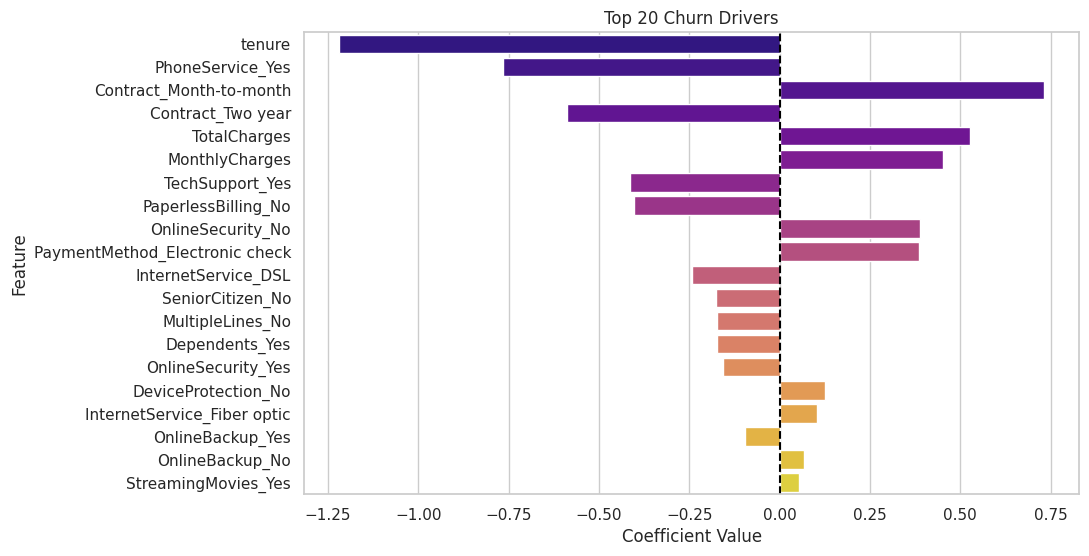

In [50]:
# Plot the 20 most important features

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20),y = "Feature",hue="Feature",x="Coefficient",palette="plasma",legend = False)
plt.title("Top 20 Churn Drivers")
plt.xlabel("Coefficient Value")
plt.axvline(0, color="black", linestyle="--")
plt.show()


In [48]:
top_positive = feature_importance.query("Coefficient > 0").head(5)
top_negative = feature_importance.query("Coefficient < 0").head(5)

In [51]:
print("="*50)
print("Top Factors Increasing Churn Likelihood:")
print("="*50)
display(top_positive)
print("="*50)
print("Top Factors Decreasing Churn Likelihood:")
print("="*50)
display(top_negative)
print("="*50)

Top Factors Increasing Churn Likelihood:


,Feature,Coefficient,Importance
37,Contract_Month-to-month,0.731998,0.731998
2,TotalCharges,0.528165,0.528165
1,MonthlyCharges,0.451102,0.451102
19,OnlineSecurity_No,0.388499,0.388499
44,PaymentMethod_Electronic check,0.385523,0.385523


Top Factors Decreasing Churn Likelihood:


,Feature,Coefficient,Importance
0,tenure,-1.218078,1.218078
12,PhoneService_Yes,-0.764889,0.764889
39,Contract_Two year,-0.589442,0.589442
30,TechSupport_Yes,-0.413312,0.413312
40,PaperlessBilling_No,-0.403437,0.403437


## Insights & Business Actions

### Objective  
Use model-derived coefficients to understand what drives churn and propose actionable strategies to retain customers.

---

### Top Factors **Increasing** Churn Likelihood

- **Contract: Month-to-month** (Coefficient = +0.73)  
  Customers on flexible month-to-month plans are **much more likely to churn** compared to those on longer-term contracts --> they lack commitment and can switch at any time.

- **TotalCharges** (Coefficient = +0.53)  
  Higher lifetime charges correspond to increased churn --> it may signal that high spenders feel they’re not receiving enough value.

- **MonthlyCharges** (Coefficient = +0.45)  
  Customers paying higher monthly bills are more likely to churn, indicating **price sensitivity** at upper ranges.

- **OnlineSecurity: No** (Coefficient = +0.39)  
  Those without online security services tend to churn more --> possibly because they perceive less benefit or feel under-engaged.

- **PaymentMethod: Electronic check** (Coefficient = +0.39)  
  Use of electronic check as payment correlates with higher churn risk --> possibly indicating lower tech adoption or payment friction.

---

### Top Factors **Decreasing** Churn Likelihood

- **Tenure** (Coefficient = −1.22)  
  Longer-tenured customers are significantly less likely to churn --> loyalty builds over time.

- **PhoneService: Yes** (Coefficient = −0.76)  
  Customers with phone service (i.e. multi-product users) are stickier --> bundling helps retention.

- **Contract: Two year** (Coefficient = −0.59)  
  Two-year contracts strongly reduce churn likelihood compared to month-to-month plans.

- **TechSupport: Yes** (Coefficient = −0.41)  
  Access to tech support correlates with higher satisfaction and lower churn.

- **PaperlessBilling: No** (Coefficient = −0.40)  
  Customers who opt out of paperless billing may be more traditional and thus less likely to churn.

---

### Business Recommendations & Actions

| Insight | Suggested Action | Expected Business Impact |
|---------|-------------------|----------------------------|
| Month-to-month customers have high churn risk | Offer **discounts or incentives** to encourage upgrades to 1- or 2-year contracts | Increases customer lock-in and reduces churn volatility |
| High spenders show churn tendencies | Introduce a **premium loyalty or reward program** | Enhances perceived value and loyalty among top customers |
| Price sensitivity at high monthly charges | Create **bundled offers** or **tiered pricing plans** | Improves perceived fairness and retention among high-cost customers |
| Churn correlates with no security subscription | Offer **free trial** or **bundle online security/tech support** as upsell | Drives feature adoption and deeper engagement |
| Electronic check users churn more | Promote **digital payment methods** (auto-pay, credit card) with incentives | Improves payment reliability and reduces churn friction |
| Tenure is a strong retention anchor | Launch **loyalty rewards** (year anniversaries, bonuses) | Strengthens retention for long-term customers |
| Bundled services reduce churn risk | Upsell **additional services** (TV, support) to single-service users | Increases customer “stickiness” |

---

### Main Takeaway  
> “The logistic regression model (AUC ≈ 0.86) not only predicts who will churn, but also reveals **why**.  
> Key drivers such as contract type, pricing sensitivity, and service add-ons give direction for retention campaigns.  
> Meanwhile, tenure, multi-service usage, and tech support help anchor customers.  
> Executing the recommended retention and upsell strategies could reduce churn significantly, especially among high-risk segments.”

---

# Conclusion and Next Steps

---

## Summary of Findings

The customer churn analysis revealed several critical insights into customer behavior and retention patterns.  
Through exploratory data analysis, feature engineering, and model experimentation, we identified the most influential drivers of churn and validated our findings using multiple predictive models.

Key highlights include:

- **Logistic Regression** emerged as the most balanced model with strong **ROC-AUC (≈ 0.86)** and **interpretability**.  
- **Contract Type**, **Monthly Charges**, and **Lack of Security/Support Services** were strong indicators of potential churn.  
- **Tenure**, **Long-term contracts**, and **Multiple service subscriptions** were strong retention anchors.  
- The model pipeline was designed with **data preprocessing, class balancing (SMOTE), and logistic regression** in a single unified flow — ensuring reproducibility and easy deployment.

---

## Model Comparison Summary

| Model | ROC-AUC | Accuracy | Key Takeaways |
|--------|----------|----------|----------------|
| **Logistic Regression** | **0.86** | 0.75 | Best tradeoff between accuracy and interpretability |
| Random Forest | 0.83 | 0.80 | High performance but less interpretable |
| XGBoost | 0.84 | 0.79 | Robust model, slightly less transparent |
| Decision Tree | 0.69 | 0.74 | Overfits and less reliable in generalization |

**Selected Model:** Logistic Regression   
**Reason:** Offers transparent insights into feature influence, business interpretability, and stable generalization.

---

## Deployment Readiness

The trained churn model has been saved as a **`.pkl` pipeline** that includes:
- Data preprocessing (scaling, encoding, and balancing)
- The trained logistic regression model
- All transformation logic for inference

This allows business users or data engineers to seamlessly deploy the model without needing to repeat preprocessing.

**Example usage:**
```python
import joblib
model = joblib.load("log_reg_churn_model.pkl")

# Predict churn probability for new customer
sample = Customer_Data
prob = model.predict_proba(sample)[0, 1]
print(f"Predicted churn probability: {prob:.2f}")
